## good read

https://data.library.virginia.edu/is-r-squared-useless/

https://stats.stackexchange.com/questions/402059/standardised-mean-absolute-error-smae-and-how-to-calculate-it

https://stats.stackexchange.com/questions/131267/how-to-interpret-error-measures/131273#131273

In [1]:
%run correlate_evolution.ipynb

%cd /work/clusterEvo/new_tests/eggNOG/

/work/clusterEvo/new_tests/eggNOG


In [2]:
import multiprocessing
import itertools
import pandas as pd
import plotly
from scipy.stats import pearsonr, mannwhitneyu
from scipy.spatial.distance import braycurtis
import igraph as ig
from Bio import SeqIO
import requests

In [3]:
single_copy = pd.read_parquet('single_copy_genes.parquet')
single_copy.head()

group_id  num_proteins  num_taxa  \
1277  arCOG00079           112       112   
1279  arCOG00081           166       166   
1519  arCOG00354           112       112   
1520  arCOG00355           106       106   
1561  arCOG00410           168       168   

                                                members  \
1277  1041930.Mtc_1976,1054217.TALC_01539,1070774.J0...   
1279  1006006.Mcup_0318,1033806.HTIA_0777,1041930.Mt...   
1519  1033806.HTIA_1426,1041930.Mtc_0671,1042877.GQS...   
1520  1033806.HTIA_0952,1041930.Mtc_0275,1042877.GQS...   
1561  1006006.Mcup_0164,1033806.HTIA_1385,1041930.Mt...   

                                                   taxa  
1277  [1041930, 1054217, 1070774, 1071085, 1094980, ...  
1279  [1006006, 1033806, 1041930, 1042877, 1054217, ...  
1519  [1033806, 1041930, 1042877, 1070774, 1071085, ...  
1520  [1033806, 1041930, 1042877, 1070774, 1071085, ...  
1561  [1006006, 1033806, 1041930, 1042877, 1054217, ...

In [4]:
single_copy.shape

(92, 5)

In [5]:
eggNOG_trees = pd.read_csv('2157_trees.tsv',
                           sep      ='\t',
                           header   =None,
                           usecols  =[1,2,3],
                           index_col=0,
                           names    =['group_id', 'fast', 'tree'])
eggNOG_trees = eggNOG_trees.reindex(index=single_copy.group_id)

group_ids = []
trees     = []
for index, row in eggNOG_trees.iterrows():
    group_ids.append(index)
    trees.append(ete3.Tree(row.tree))

pool          = multiprocessing.Pool(processes = 10)
dist_matrices = pool.map(get_matrix_from_tree, trees)

# table = {group:matrix for group, matrix in zip(group_ids, dist_matrices)}

In [41]:
table = {group:matrix for group, matrix in zip(group_ids, trees)}

In [5]:
# del(dist_matrices)
# del(trees)
# del(group_ids)

# group_ids = []
# trees     = []
# for group_id in single_copy.group_id.values:
#     group_ids.append(group_id)
#     trees.append(ete3.Tree(f'trees/{group_id}.nwk'))

# pool          = multiprocessing.Pool(processes = 10)
# dist_matrices = pool.map(get_matrix_from_tree, trees)

In [6]:
def run_coevol(matrices):
    m1 = matrices[0].copy()
    m2 = matrices[1].copy()
    r2 = assess_coevolution(m1, m2, gene_sep='.', geneIDs=True)[1]
    
    return(r2)

matrix1 = dist_matrices[0].copy()
matrix2 = dist_matrices[1].copy()
run_coevol((matrix1, matrix2))

0.8713248922984702

In [7]:
pool   = multiprocessing.Pool(processes=10)
odr_r2 = np.array(pool.map(run_coevol, itertools.combinations(dist_matrices, 2)))

In [8]:
group_pairs = []
for pair in itertools.combinations(group_ids, 2):
    group_pairs.append(pair)

group_pairs = np.array(group_pairs)

In [9]:
odr_df = pd.DataFrame(columns=['group1', 'group2', 'Rsquared'],
                      data   =zip(group_pairs[:, 0],
                                  group_pairs[:, 1],
                                  odr_r2))

odr_df['group_pair'] = odr_df[['group1', 'group2']].agg(frozenset, axis=1)
odr_df.set_index('group_pair', inplace=True)

odr_df.head()

group1      group2  Rsquared
group_pair                                                
(arCOG00081, arCOG00079)  arCOG00079  arCOG00081  0.871325
(arCOG00354, arCOG00079)  arCOG00079  arCOG00354  0.562008
(arCOG00355, arCOG00079)  arCOG00079  arCOG00355  0.850273
(arCOG00410, arCOG00079)  arCOG00079  arCOG00410  0.957535
(arCOG00487, arCOG00079)  arCOG00079  arCOG00487  0.850984

In [10]:
def get_braycurtis(pair):
    (index1, row1), (index2, row2) = pair

    taxa1 = re.findall('(?:^|,)(\d+)', row1.members)
    taxa2 = re.findall('(?:^|,)(\d+)', row2.members)

    freq1 = Counter(taxa1)
    freq2 = Counter(taxa2)

    freq1_input = []
    freq2_input = []
    for taxon in set(taxa1).union(taxa2):
        if taxon in freq1:
            freq1_input.append(freq1[taxon])
        else:
            freq1_input.append(0)
        if taxon in freq2:
            freq2_input.append(freq2[taxon])
        else:
            freq2_input.append(0)    
            
    return(row1.group_id, 
           row2.group_id, 
           1 - braycurtis(freq1_input, freq2_input))

pool               = multiprocessing.Pool(processes=10)
braycurtis_indices = pool.map(get_braycurtis, 
                              itertools.combinations(single_copy.iterrows(), 2))

# braycurtis_indices = np.array(braycurtis_indices)

In [11]:
braycurtis_df = pd.DataFrame(columns=['group1', 'group2', 'braycurtis'],
                             data   =braycurtis_indices)

braycurtis_df['group_pair'] = braycurtis_df[['group1', 'group2']].agg(frozenset, axis=1)
braycurtis_df.set_index('group_pair', inplace=True)

In [12]:
odr_df = odr_df.join(braycurtis_df.braycurtis)

odr_df['coevol_metric'] = odr_df.Rsquared * odr_df.braycurtis

odr_df.reset_index(drop=True).to_parquet('odr_regression-single_copies.parquet')

odr_df.head()

group1      group2  Rsquared  braycurtis  \
group_pair                                                               
(arCOG00081, arCOG00079)  arCOG00079  arCOG00081  0.871325    0.798561   
(arCOG00354, arCOG00079)  arCOG00079  arCOG00354  0.562008    0.857143   
(arCOG00355, arCOG00079)  arCOG00079  arCOG00355  0.850273    0.807339   
(arCOG00410, arCOG00079)  arCOG00079  arCOG00410  0.957535    0.800000   
(arCOG00487, arCOG00079)  arCOG00079  arCOG00487  0.850984    0.800000   

                          coevol_metric  
group_pair                               
(arCOG00081, arCOG00079)       0.695806  
(arCOG00354, arCOG00079)       0.481721  
(arCOG00355, arCOG00079)       0.686459  
(arCOG00410, arCOG00079)       0.766028  
(arCOG00487, arCOG00079)       0.680787

In [88]:
def run_rf(trees):
    
    tmp_trees = []
    for _ in trees:
        tmp = _.copy()
        for leaf in tmp.get_leaves():
            leaf.name = leaf.name.split('.')[0]
            
        tmp_trees.append(tmp)
    
    tmp_rf = tmp_trees[0].robinson_foulds(tmp_trees[1])
    
    return(tmp_rf[0]/tmp_rf[1])

pool    = multiprocessing.Pool(processes=10)
rf_norm = pool.map(run_rf, itertools.combinations(trees, 2))

In [89]:
rf_df = pd.DataFrame(columns=['group1', 'group2', 'rf'],
                      data  =zip(group_pairs[:, 0],
                                 group_pairs[:, 1],
                                 rf_norm))

rf_df['group_pair'] = rf_df[['group1', 'group2']].agg(frozenset, axis=1)
rf_df.set_index('group_pair', inplace=True)

rf_df.head()

group1      group2        rf
group_pair                                                
(arCOG00081, arCOG00079)  arCOG00079  arCOG00081  0.633028
(arCOG00354, arCOG00079)  arCOG00079  arCOG00354  0.489362
(arCOG00355, arCOG00079)  arCOG00079  arCOG00355  0.500000
(arCOG00410, arCOG00079)  arCOG00079  arCOG00410  0.527273
(arCOG00487, arCOG00079)  arCOG00079  arCOG00487  0.563636

In [16]:
geo_matrix = pd.read_csv('geodesic_distances.csv', index_col=0)
geo_matrix = geo_matrix.reindex(index  =group_ids,
                                columns=group_ids)

triu_indices        = np.triu_indices_from(geo_matrix, k=1)
geo_df              = pd.DataFrame()
geo_df['group1']    = geo_matrix.index[ triu_indices[0]]
geo_df['group2']    = geo_matrix.index[ triu_indices[1]]
geo_df['geodesic' ] = geo_matrix.values[triu_indices]

geo_df['group_pair'] = geo_df[['group1', 'group2']].agg(frozenset, axis=1)
geo_df.set_index('group_pair', inplace=True)

geo_df.head()

group1      group2  geodesic
group_pair                                                
(arCOG00081, arCOG00079)  arCOG00079  arCOG00081  2.788086
(arCOG00354, arCOG00079)  arCOG00079  arCOG00354  6.945581
(arCOG00355, arCOG00079)  arCOG00079  arCOG00355  3.927274
(arCOG00410, arCOG00079)  arCOG00079  arCOG00410  2.055330
(arCOG00487, arCOG00079)  arCOG00079  arCOG00487  3.463589

In [17]:
string = pd.read_parquet('duplications/few_duplications-string.parquet')

string = string.query('group1 in @single_copy.group_id & '
                      'group2 in @single_copy.group_id').copy()

string['group_pair'] = string[['group1', 'group2']].agg(frozenset, axis=1)
string.drop_duplicates(subset='group_pair', inplace=True)

neighors     = string.query('neighborhood >= 700')
not_neighors = string.query('neighborhood <= 200')


data_columns = ['Rsquared', 'coevol_metric', 'braycurtis']

In [93]:
string.shape, neighors.shape, not_neighors.shape

((2098, 11), (95, 11), (1791, 11))

In [32]:
similar_distribution_genes         = braycurtis_df.query('braycurtis >= 0.9').index
similar_distribution_neighbors     = neighors.query(    'group_pair in @similar_distribution_genes')
similar_distribution_not_neighbors = not_neighors.query('group_pair in @similar_distribution_genes')

In [33]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10))
for ax, column in zip(axs, data_columns):
    
    neighors     = string.query('neighborhood >= 700')
    not_neighors = string.query('neighborhood <= 200')

    neighors_odr     = odr_df.query('group_pair in @neighors.group_pair'    )[column].values
    not_neighors_odr = odr_df.query('group_pair in @not_neighors.group_pair')[column].values

    hypothesis = mannwhitneyu(not_neighors_odr,
                              neighors_odr)
    
    if column == 'mse':
        effect_size = cles(neighors_odr, not_neighors_odr)
    else:
        effect_size = cles(not_neighors_odr, neighors_odr)

    sns.kdeplot(neighors_odr, shade=True,     label=f'{len(neighors_odr)} neighbor pairs',     ax=ax)
    sns.kdeplot(not_neighors_odr, shade=True, label=f'{len(not_neighors_odr)} not neighbor pairs', ax=ax)

    if column == 'Rsquared':
        ax.set_title(f'ODR Rˆ2 between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');
    else:
        ax.set_title(f'adjusted ODR Rˆ2 between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

In [34]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10))
for ax, column in zip(axs, data_columns):
    
    neighors_odr     = odr_df.query('group_pair in @similar_distribution_neighbors.group_pair'    )[column].values
    not_neighors_odr = odr_df.query('group_pair in @similar_distribution_not_neighbors.group_pair')[column].values

    hypothesis = mannwhitneyu(not_neighors_odr,
                              neighors_odr)
    
    if column == 'mse':  
        effect_size = cles(neighors_odr, not_neighors_odr)
    else:
        effect_size = cles(not_neighors_odr, neighors_odr)

    sns.kdeplot(neighors_odr, shade=True,     label=f'{len(neighors_odr)} neighbor pairs',     ax=ax)
    sns.kdeplot(not_neighors_odr, shade=True, label=f'{len(not_neighors_odr)} not neighbor pairs', ax=ax)

    if column == 'Rsquared':
        ax.set_title(f'ODR Rˆ2 between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');
    else:
        ax.set_title(f'ODR corrected Rˆ2 between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

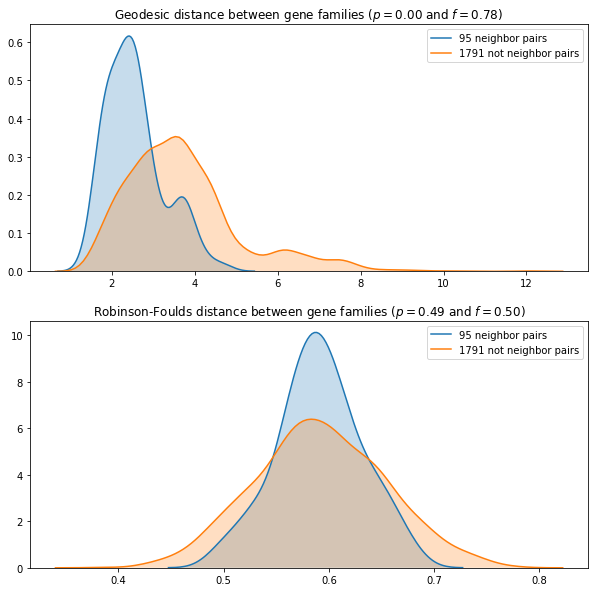

In [90]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10))
    
neighors_geo     = geo_df.query('group_pair in @neighors.group_pair'    ).geodesic.values
not_neighors_geo = geo_df.query('group_pair in @not_neighors.group_pair').geodesic.values

hypothesis = mannwhitneyu(neighors_geo,
                          not_neighors_geo)
effect_size = cles(neighors_geo, 
                   not_neighors_geo)

sns.kdeplot(neighors_geo,     shade=True, label=f'{len(neighors_geo)} neighbor pairs',     ax=axs[0])
sns.kdeplot(not_neighors_geo, shade=True, label=f'{len(not_neighors_geo)} not neighbor pairs', ax=axs[0])
axs[0].set_title(f'Geodesic distance between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

neighors_rf     = rf_df.query('group_pair in @neighors.group_pair'    ).rf.values
not_neighors_rf = rf_df.query('group_pair in @not_neighors.group_pair').rf.values

hypothesis = mannwhitneyu(neighors_rf,
                          not_neighors_rf)
effect_size = cles(neighors_rf, 
                   not_neighors_rf)

sns.kdeplot(neighors_rf,     shade=True, label=f'{len(neighors_rf)} neighbor pairs',     ax=axs[1])
sns.kdeplot(not_neighors_rf, shade=True, label=f'{len(not_neighors_rf)} not neighbor pairs', ax=axs[1])
axs[1].set_title(f'Robinson-Foulds distance between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

In [91]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10))
    
neighors_geo     = geo_df.query('group_pair in @similar_distribution_neighbors.group_pair'    ).geodesic.values
not_neighors_geo = geo_df.query('group_pair in @similar_distribution_not_neighbors.group_pair').geodesic.values

hypothesis = mannwhitneyu(neighors_geo,
                          not_neighors_geo)
effect_size = cles(neighors_geo, 
                   not_neighors_geo)

sns.kdeplot(neighors_geo,     shade=True, label=f'{len(neighors_geo)} neighbor pairs',     ax=axs[0])
sns.kdeplot(not_neighors_geo, shade=True, label=f'{len(not_neighors_geo)} not neighbor pairs', ax=axs[0])
axs[0].set_title(f'Geodesic distance between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

neighors_rf     = rf_df.query('group_pair in @similar_distribution_neighbors.group_pair'    ).rf.values
not_neighors_rf = rf_df.query('group_pair in @similar_distribution_not_neighbors.group_pair').rf.values

hypothesis = mannwhitneyu(neighors_rf,
                          not_neighors_rf)
effect_size = cles(neighors_rf, 
                   not_neighors_rf)

sns.kdeplot(neighors_rf,     shade=True, label=f'{len(neighors_rf)} neighbor pairs',     ax=axs[1])
sns.kdeplot(not_neighors_rf, shade=True, label=f'{len(not_neighors_rf)} not neighbor pairs', ax=axs[1])
axs[1].set_title(f'Robinson-Foulds distance between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');